In [2]:
import os
import shutil

# Define the path to the working directory
working_directory_path = '/kaggle/working'

# List all files and directories in the working directory
files_and_dirs = os.listdir(working_directory_path)

# Delete all files and directories in the working directory
for item in files_and_dirs:
    item_path = os.path.join(working_directory_path, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Verify that the working directory is empty
if not os.listdir(working_directory_path):
    print("Working directory is now empty.")
else:
    print("Failed to clear the working directory.")



Working directory is now empty.


In [3]:

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout, BatchNormalization,MaxPooling2D, Activation
import tensorflow as tf
from tensorflow import keras
from keras.layers import  GlobalAveragePooling2D
from keras.layers import  ZeroPadding2D
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import os

# Specify the directory containing your data
base_dir_path = '/kaggle/input/date-fruit-with-12-classes-mormo/Date Fruit with 12 classes/Date Fruit with 12 classes'

# Initialize a dictionary to store class counts
class_count = {}

# Iterate through the files in the directory
for root, dirs, files in os.walk(base_dir_path):
    for file in files:
        # Extract the class label from the file path (you may need to adjust this based on your directory structure)
        class_label = os.path.basename(root)

        # Update the class count
        if class_label in class_count:
            class_count[class_label] += 1
        else:
            class_count[class_label] = 1

# Display the class labels and their counts
for label, count in class_count.items():
    print(f"{label}: {count}")

Galaxy: 190
Rutab: 146
Sukkary not found: 988
Halawy: 168
Medjool: 135
Segai: 47
Nabtat Ali: 193
Mabroom: 1395
Masyihia: 58
Ajwa: 1372
Sukkari: 410
Meneifi: 232


In [5]:
data_dir_path = '/kaggle/working/dataset_split/'

In [6]:
pip install split-folders

  Obtaining dependency information for split-folders from https://files.pythonhosted.org/packages/b6/d5/307d63c03356bad6e141d8718d3f4116f51bd9c4b09e2614ffcee1f3c6fd/split_folders-0.5.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [7]:
import splitfolders

In [8]:
# Split the data into training, validation, and test sets using split_folders
splitfolders.ratio(base_dir_path, data_dir_path, seed=42, ratio=(0.8, 0.10, 0.10), group_prefix=None)

Copying files: 5334 files [00:21, 252.41 files/s]


# **Epochs and sizes**

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNEL = 3
EPOCHS =10
input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNEL)
target_size = (IMAGE_SIZE , IMAGE_SIZE)

In [10]:
# Use ImageDataGenerator to rescale the images
train_datagen = ImageDataGenerator( rescale=1./255,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

valid_datagen = ImageDataGenerator( rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator( rescale=1./255, horizontal_flip=True)

In [11]:
# Load the images
train_generator = train_datagen.flow_from_directory(directory=data_dir_path +'train',
                                                    target_size=target_size,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=1234)

valid_generator = valid_datagen.flow_from_directory(directory=data_dir_path +'val',
                                                    target_size=target_size,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=1234)


test_generator = test_datagen.flow_from_directory(directory=data_dir_path +'test',
                                                  target_size=target_size,
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=1234)

Found 4263 images belonging to 12 classes.
Found 528 images belonging to 12 classes.
Found 543 images belonging to 12 classes.


In [12]:
len(train_generator)

134

In [13]:
classes= train_generator.class_indices
class_names = list(classes.keys())
class_names

['Ajwa',
 'Galaxy',
 'Halawy',
 'Mabroom',
 'Masyihia',
 'Medjool',
 'Meneifi',
 'Nabtat Ali',
 'Rutab',
 'Segai',
 'Sukkari',
 'Sukkary not found']

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D, BatchNormalization

# Create a ResNet-50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model on top of the ResNet-50 base model
model = Sequential()

# Add the ResNet-50 base model to the new model
model.add(base_model)

# Drop certain layers (e.g., drop some residual blocks)
for layer in base_model.layers[-30:20]:  # Example: Drop the first few layers
    layer.trainable = False
    
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# Add a Conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#Add additional layers for classification
model.add(GlobalMaxPooling2D())

# Add BatchNormalization layer
model.add(BatchNormalization())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Adding Dropout for regularization

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4)) 

model.add(Dense(12, activation='softmax'))  

# Display the modified model summary
model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          1179712   
                                                                 
 global_max_pooling2d (Glob  (None, 64)                0         
 alMaxPooling2D)                                                 
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                         

In [15]:
for layer in model.layers:
    print(layer.name)

resnet50
conv2d
global_max_pooling2d
batch_normalization
dense
batch_normalization_1
dropout
dense_1
dropout_1
dense_2


In [16]:
import tensorflow as tf
# Compile the model with the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

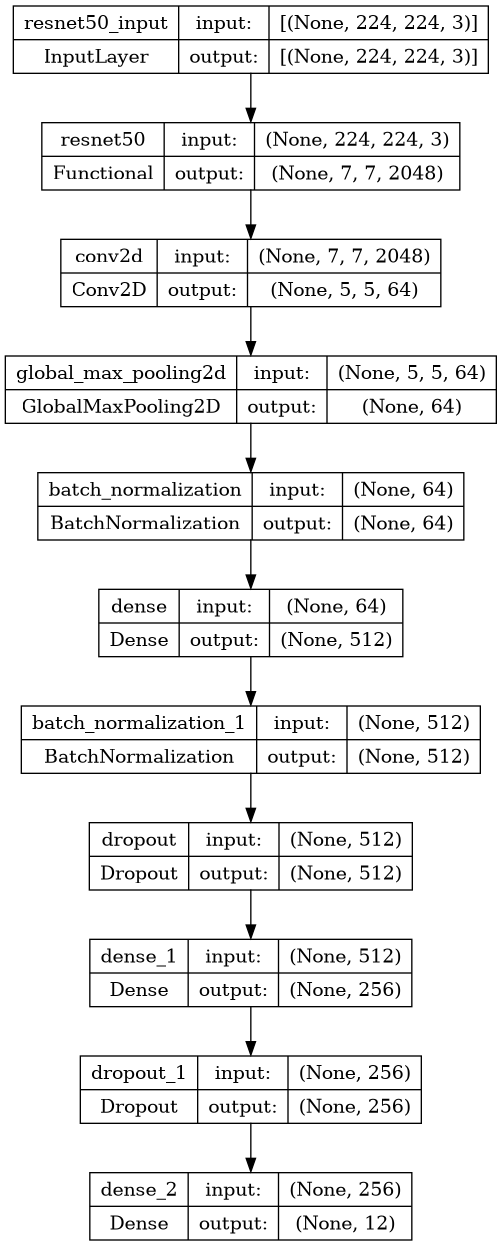

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [19]:
# Creating callbacks for the model.
# If the model dosen't continue to improve (loss), the trainning will stop.

# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model_mcp = ModelCheckpoint(filepath = "/kaggle/working/model_weights.h5", monitor = 'val_accuracy',
                      save_best_only = True, verbose = 1)

In [20]:
import time

# Record the start time
start_time = time.time()

In [21]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,verbose= 1,
          validation_steps=STEP_SIZE_VALID,epochs=EPOCHS,
                     callbacks=[model_es, model_rlr, model_mcp])

Epoch 1/10
133/133 [==============================] - ETA: 0s - loss: 1.1160 - accuracy: 0.6731
Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to /kaggle/working/model_weights.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - 119s 569ms/step - loss: 1.1160 - accuracy: 0.6731 - val_loss: 2.4393 - val_accuracy: 0.1875 - lr: 1.0000e-04
Epoch 2/10
133/133 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.8672
Epoch 2: val_accuracy improved from 0.18750 to 0.21484, saving model to /kaggle/working/model_weights.h5
133/133 [==============================] - 73s 543ms/step - loss: 0.4361 - accuracy: 0.8672 - val_loss: 2.2706 - val_accuracy: 0.2148 - lr: 1.0000e-04
Epoch 3/10
133/133 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.9088
Epoch 3: val_accuracy did not improve from 0.21484
133/133 [==============================] - 72s 532ms/step - loss: 0.3005 - accuracy: 0.9088 - val_loss: 2.2599 - val_accuracy: 0.1797 - lr: 1.0000e-04
Epoch 4/10
133/133 [==============================] - ETA: 0s - loss: 0.2162 - accuracy: 0.9376
Epoch 4: val_accuracy improved from 0.21484 to 0.22266, saving model to /kaggle/working/model_weights.

In [22]:
# Record the end time
end_time = time.time()

# Calculate and display the training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 772.3973426818848 seconds


In [23]:
# Extract the final training and validation accuracy and convert to percentage
final_training_accuracy = history.history['accuracy'][-1] * 100
final_validation_accuracy = history.history['val_accuracy'][-1] * 100

# Print with two decimal places
print(f"Final Training Accuracy: {final_training_accuracy:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy:.2f}%")

Final Training Accuracy: 97.16%
Final Validation Accuracy: 93.75%


In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [25]:
# Extract learning rate history from ReduceLROnPlateau callback
lr_history = history.history['lr']

# Extract training and validation accuracy and loss
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

543/543 [==============================] - 7s 10ms/step


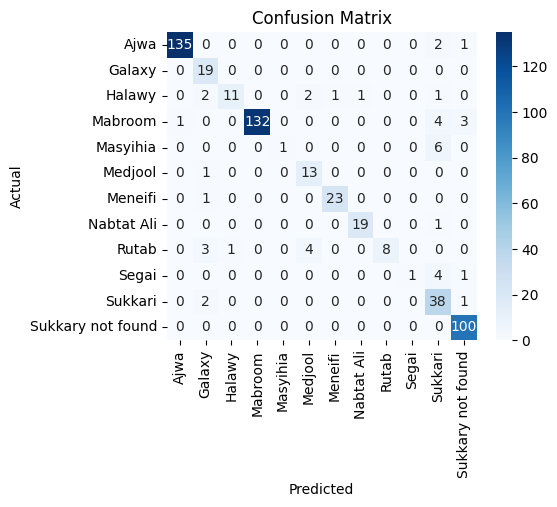

                   precision    recall  f1-score   support

             Ajwa       0.99      0.98      0.99       138
           Galaxy       0.68      1.00      0.81        19
           Halawy       0.92      0.61      0.73        18
          Mabroom       1.00      0.94      0.97       140
         Masyihia       1.00      0.14      0.25         7
          Medjool       0.68      0.93      0.79        14
          Meneifi       0.96      0.96      0.96        24
       Nabtat Ali       0.95      0.95      0.95        20
            Rutab       1.00      0.50      0.67        16
            Segai       1.00      0.17      0.29         6
          Sukkari       0.68      0.93      0.78        41
Sukkary not found       0.94      1.00      0.97       100

         accuracy                           0.92       543
        macro avg       0.90      0.76      0.76       543
     weighted avg       0.94      0.92      0.91       543



In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

# Load the saved model
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/kaggle/working/model_weights.h5")

# Use the test data generator to generate predictions for the test set
test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Get the true labels from the test data generator
true_labels = test_generator.classes

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('Classification Matrix.png', format='png')
plt.show()

# Print the classification report
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
print(classification_rep)

# Save the classification report to a text file
with open("/kaggle/working/classification_report.txt", "w") as text_file:
    text_file.write(classification_rep)

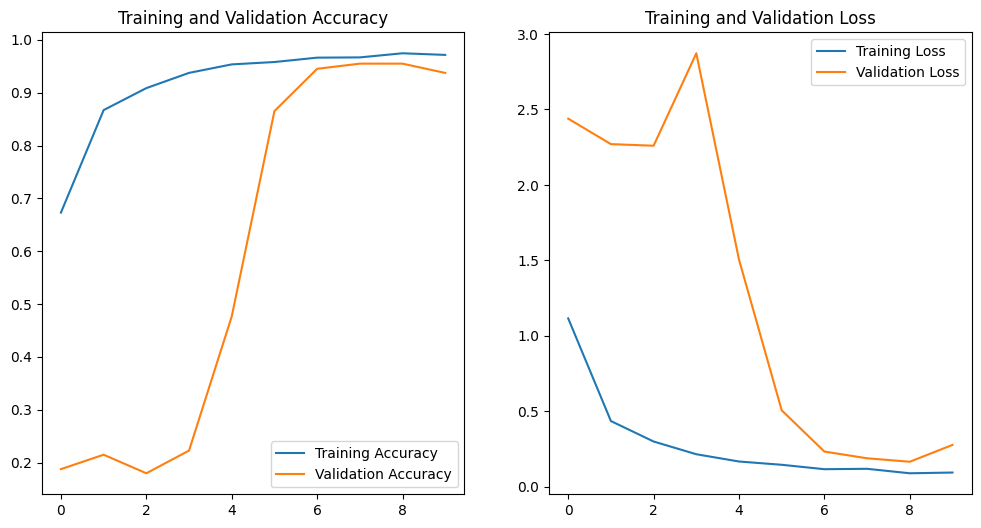

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),training_accuracy , label='Training Accuracy')
plt.plot(range(EPOCHS),validation_accuracy , label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),training_loss  , label='Training Loss')
plt.plot(range(EPOCHS),validation_loss  , label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('TrainingTestingAccuracyLoss.png', format='png')
plt.show()

In [28]:
model.save("/kaggle/working/model/pbmodel")
model.save("/kaggle/working/model/model.h5")
model.save_weights("/kaggle/working/model/weights.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
